In [29]:
# Install and import TF2
!pip install -q tensorflow==2.0.0
import tensorflow as tf
print(tf.__version__)

2.0.0


In [0]:
# Additional imports
from tensorflow.keras.layers import Input,Dense,GlobalMaxPool1D,SimpleRNN,GRU,LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD,Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [0]:
# we load inb CSV with SBUX stockprices from 2013-2018
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

In [32]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [33]:
df.tail()

,date,open,high,low,close,volume,Name
1254,2018-02-01,56.280,56.42,55.89,56.00,14690146,SBUX
1255,2018-02-02,55.900,56.32,55.70,55.77,15358909,SBUX
1256,2018-02-05,55.530,56.26,54.57,54.69,16059955,SBUX
1257,2018-02-06,53.685,56.06,53.56,55.61,17415065,SBUX
1258,2018-02-07,55.080,55.43,54.44,54.46,13927022,SBUX


In [0]:
# Start by doing the wrong thing - trying to predict the price itself
series = df['close'].values.reshape(-1,1)

In [0]:
# Normalize the data
# The boundary is just an approximation
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [36]:
### Build the dataset
# let's see if we can use T past values to predict the next value
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1) # Now the data should be NxTxD
Y = np.array(Y)
N = len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (1249, 10, 1) Y.shape (1249,)


In [37]:
### Try Autoregressive RNN model
i = Input(shape=(T,1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i,x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.1),
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:],Y[-N//2:]),
)

Train on 624 samples, validate on 625 samples
Epoch 1/80
624/624 [==============================] - 4s 6ms/sample - loss: 0.2075 - val_loss: 0.1945
Epoch 2/80
624/624 [==============================] - 0s 311us/sample - loss: 0.0206 - val_loss: 0.1144
Epoch 3/80
624/624 [==============================] - 0s 284us/sample - loss: 0.0093 - val_loss: 0.0546
Epoch 4/80
624/624 [==============================] - 0s 292us/sample - loss: 0.0075 - val_loss: 0.0468
Epoch 5/80
624/624 [==============================] - 0s 302us/sample - loss: 0.0058 - val_loss: 0.0576
Epoch 6/80
624/624 [==============================] - 0s 287us/sample - loss: 0.0057 - val_loss: 0.0420
Epoch 7/80
624/624 [==============================] - 0s 276us/sample - loss: 0.0065 - val_loss: 0.0409
Epoch 8/80
624/624 [==============================] - 0s 281us/sample - loss: 0.0060 - val_loss: 0.0517
Epoch 9/80
624/624 [==============================] - 0s 274us/sample - loss: 0.0060 - val_loss: 0.0538
Epoch 10/80
624/624 

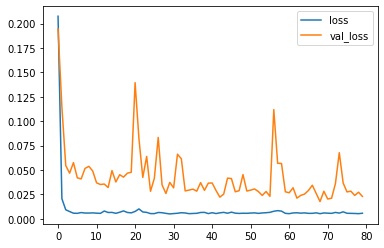

In [38]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1249, 1)


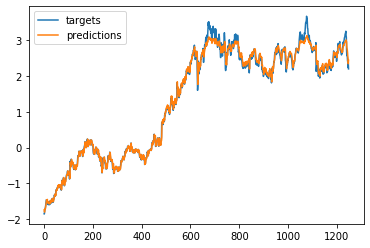

In [39]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()

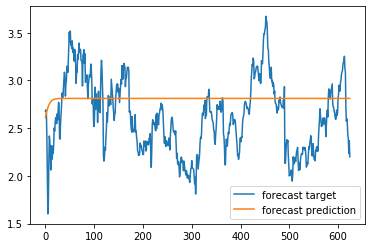

In [40]:
# Forecast future values (use only self-predictions for making predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] #!-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1,T, 1))[0,0] #1x1 array => scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x,-1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

# Part 2: Work with Returns

In [0]:
# calculate returns by first shifting the data
df['PrevClose'] = df['close'].shift(1) # move everything up 1

# so now its like
# close  / prev. close
# x[2] x[1]
# x[3] x[2]
# x[4] x[3]
# ...
# x[t] x[t-1]

In [42]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915


In [0]:
# the the return is
# x[t] -x[t-1] / x[t-1]
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']

In [44]:
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


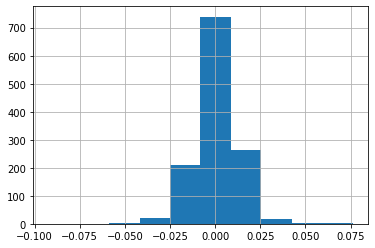

In [45]:
# Now let's try LSTMs to predict Returns
df['Return'].hist()

In [0]:
series = df['Return'].values[1:].reshape(-1,1)

# normalize the data
# note: I didn't think about where the true boundary is, this is just aprox
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
scaler = scaler.transform(series).flatten()

In [47]:
# build the dataset
# let's see if we can use T past values to predict the next val
T = 10
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1,T,1) # Now the data should be NxTxD
Y = np.array(Y)
N = len(X)
print("X.shape",X.shape,"Y.shape",Y.shape)

X.shape (1248, 10, 1) Y.shape (1248, 1)


In [48]:
### Try Autoregressive RNN model
i = Input(shape=(T,1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i,x)
model.compile(
    loss='mse',
    optimizer=Adam(lr=0.01),
)

# train the RNN
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:],Y[-N//2:]),
)

Train on 624 samples, validate on 624 samples
Epoch 1/80
624/624 [==============================] - 2s 3ms/sample - loss: 3.7403e-04 - val_loss: 1.6997e-04
Epoch 2/80
624/624 [==============================] - 0s 268us/sample - loss: 1.7676e-04 - val_loss: 1.9639e-04
Epoch 3/80
624/624 [==============================] - 0s 271us/sample - loss: 1.4681e-04 - val_loss: 1.6267e-04
Epoch 4/80
624/624 [==============================] - 0s 280us/sample - loss: 1.4878e-04 - val_loss: 1.6868e-04
Epoch 5/80
624/624 [==============================] - 0s 324us/sample - loss: 1.4734e-04 - val_loss: 1.6257e-04
Epoch 6/80
624/624 [==============================] - 0s 297us/sample - loss: 1.4356e-04 - val_loss: 1.7111e-04
Epoch 7/80
624/624 [==============================] - 0s 287us/sample - loss: 1.4665e-04 - val_loss: 1.6243e-04
Epoch 8/80
624/624 [==============================] - 0s 286us/sample - loss: 1.4457e-04 - val_loss: 1.6751e-04
Epoch 9/80
624/624 [==============================] - 0s 258

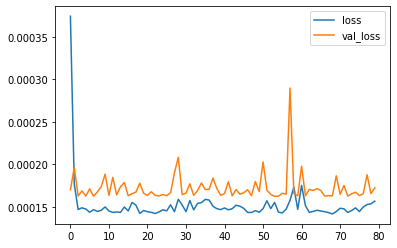

In [49]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

(1248, 1)


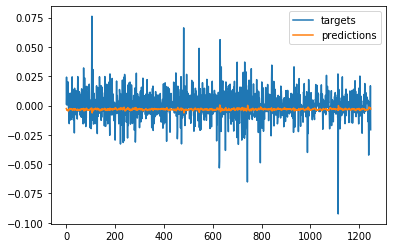

In [50]:
# One-step forecast using true targets
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:,0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()

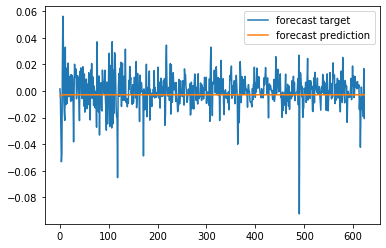

In [51]:
# Forecast future values (use only self-predictions for making predictions)

validation_target = Y[-N//2:]
validation_predictions = []

# last train input
last_x = X[-N//2] #!-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1,T, 1))[0,0] #1x1 array => scalar

  # update the predictions list
  validation_predictions.append(p)

  # make the new input
  last_x = np.roll(last_x,-1)
  last_x[-1] = p

plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend()

# Part 3: Binary Classification on D=5 Time Series

In [0]:
# Now turn the full data into numpy arrays

# Not ye in the final 'X' format
input_data = df[['open','high','low','close','volume']].values
targets = df['Return'].values

In [0]:
# Now make the actual data which will go into the neural network
T = 10 # the number of time steps to look at to make a prediction for the next day
D = input_data.shape[1]
N = len(input_data) - T # (e.g if T=10 and ou have 11 data pointsthen we only have 1)

In [0]:
# Normalize the inputs
Ntrain = len(input_data) * 2 // 3
scaler = StandardScaler()
scaler.fit(input_data[:Ntrain+T])
input_data = scaler.transform(input_data)

In [0]:
# Setup X_train and y_train

X_train = np.zeros((Ntrain, T, D))
y_train = np.zeros(Ntrain)

for t in range(Ntrain):
  X_train[t,:,:] = input_data[t:t+T]
  y_train[t] =(targets[t+T]>0)

In [0]:
# Setup X_test and y_test
X_test = np.zeros((N-Ntrain, T, D))
y_test = np.zeros(N-Ntrain)

for u in range(N-Ntrain):
  # u counts from 0...(N - Ntrain)
  # t counts from Ntrain...N
  t = u + Ntrain
  X_test[u,:,:] = input_data[t:t+T]
  y_test[u] = (targets[t+T] > 0)

In [0]:
# Make the RNN
i = Input(shape=(T,D))
x = LSTM(50)(i)
x = Dense(1,activation='sigmoid')(x)
model = Model(i,x)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(lr=0.001),
    metrics=['accuracy'],
)

In [63]:
# train the RNN
r = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=300,
    validation_data=(X_test,y_test),
)

Train on 839 samples, validate on 410 samples
Epoch 1/300
839/839 [==============================] - 0s 348us/sample - loss: 0.5927 - accuracy: 0.6722 - val_loss: 0.7606 - val_accuracy: 0.4829
Epoch 2/300
839/839 [==============================] - 0s 335us/sample - loss: 0.5913 - accuracy: 0.6687 - val_loss: 0.7707 - val_accuracy: 0.4756
Epoch 3/300
839/839 [==============================] - 0s 380us/sample - loss: 0.5853 - accuracy: 0.6663 - val_loss: 0.7645 - val_accuracy: 0.4732
Epoch 4/300
839/839 [==============================] - 0s 332us/sample - loss: 0.5824 - accuracy: 0.6770 - val_loss: 0.7685 - val_accuracy: 0.4756
Epoch 5/300
839/839 [==============================] - 0s 315us/sample - loss: 0.5835 - accuracy: 0.6615 - val_loss: 0.7756 - val_accuracy: 0.4829
Epoch 6/300
839/839 [==============================] - 0s 343us/sample - loss: 0.5775 - accuracy: 0.6889 - val_loss: 0.7736 - val_accuracy: 0.4878
Epoch 7/300
839/839 [==============================] - 0s 341us/sample -

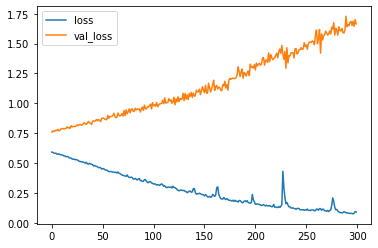

In [64]:
# Plot loss per iteration
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

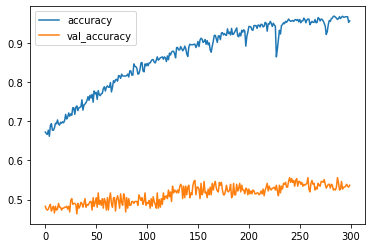

In [65]:
# Plot loss per iteration
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()